In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import lightkurve as lk
from matplotlib import pyplot as  plt
import numpy as np
from astropy.table import Table
from analysis_tools_cython import *

In [3]:
plt.rcParams["figure.figsize"] = (20, 10)

## WASP 100 in XRP data

In [4]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

In [5]:
lookup[lookup.TIC_ID == 38846515]

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


### Reading in the lightcurve and cleaning

In [6]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",sector=1)

In [7]:
data = data['time','corrected flux','quality','flux error']

flat_flux, trend_flux = smoothing(data,method='median')
a = Table()
a['time'] = data[data.colnames[0]]
a['flux'] = flat_flux - np.ones(len(flat_flux))
a['quality'] = data[data.colnames[2]]
a['flux_error'] = data[data.colnames[3]]
#table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

### My automated search

In [8]:
timestep = calculate_timestep(data)
factor = ((1/48)/timestep)

T1 = test_statistic_array(flux,60 * factor)

m, n = np.unravel_index(
T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
#Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n-math.floor((m-1)/2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean() 
Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic

### Creating the cutout of the deepest event

In [9]:
asym, width1, width2, depth, info = calc_shape(m,n,t,flux,quality,flux_error,n_m_bg_start=2)
s = classify(m,n,real,asym)

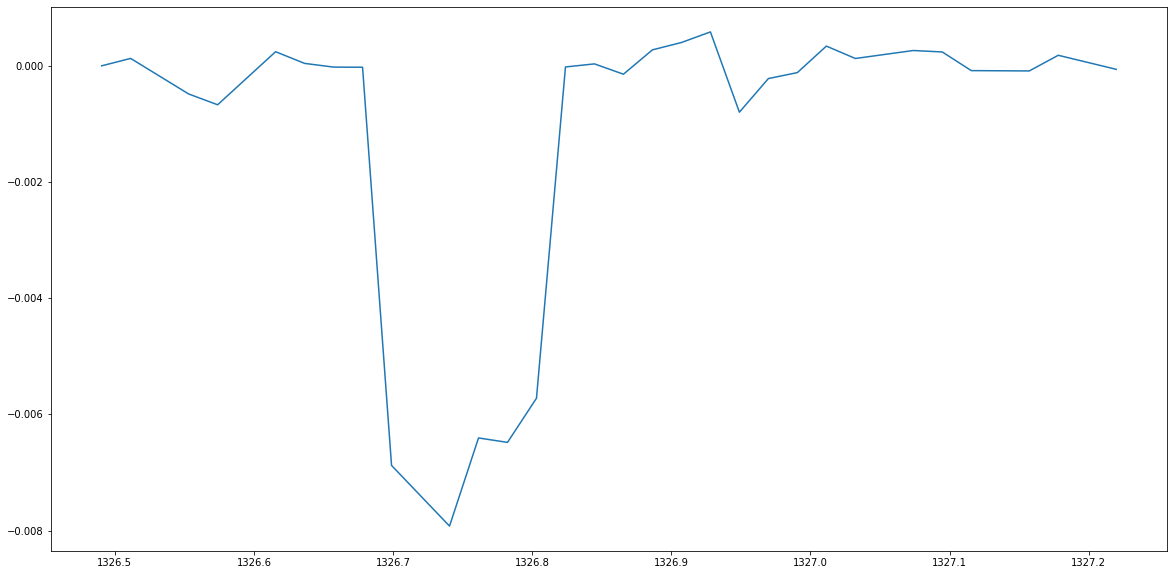

In [10]:
plt.plot(info[0],info[1])

### Flipping the lightcurves

For a test scenario, we flip the lightcurve based on the minimum point of this cutout, since we know the strongest event to be the transiting event and the midtransit point is where the data appears the lowest. However, I am aware that there can be the case where the minimum point is an outliter. So I need to think about that. But for now, we continue this way.

In [11]:
t = info[0]
flux = info[1]

In [12]:
min_flux_ind = np.argmin(flux)

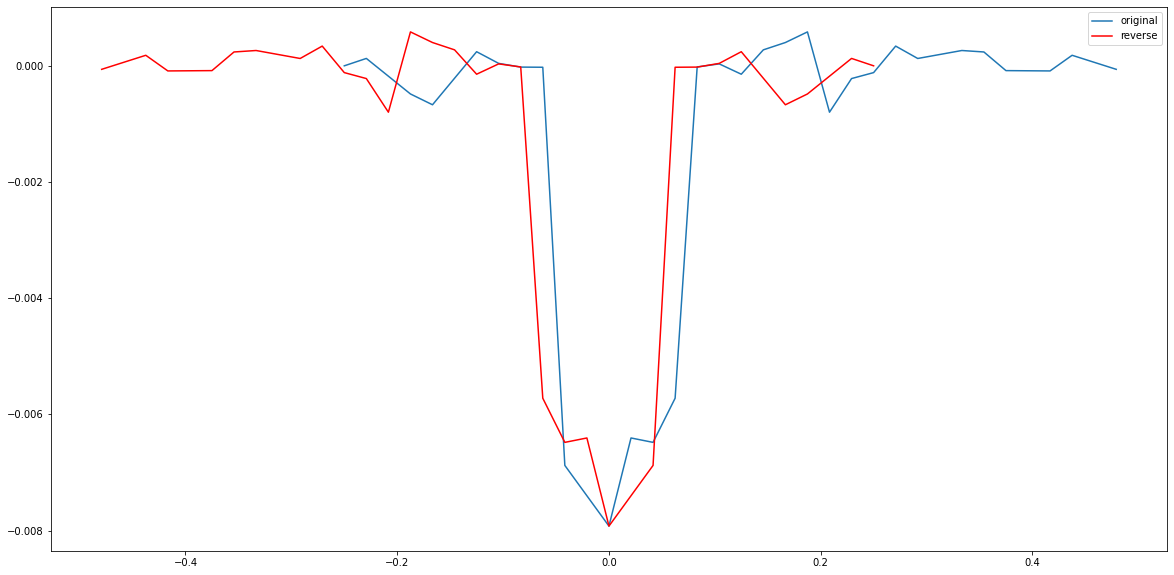

In [13]:
plt.figure(figsize=(20,10))
plt.plot(t - t[min_flux_ind],flux,label='original')


#plt.plot(t - t[min_flux_ind],np.roll(flux,5),color='blue',label='original shifted')
#plt.plot(time - time[min_flux_ind],flux,color='black',label='original')
plt.plot(t[::-1]-t[np.argmin(flux[::-1])],flux,color="red",label='reverse')
plt.legend()

In [14]:
x_forward = t - t[min_flux_ind]
y_forward = flux

In [15]:
x_backward = (t[::-1]-t[np.argmin(flux[::-1])])[::-1]
y_backward = flux[::-1]

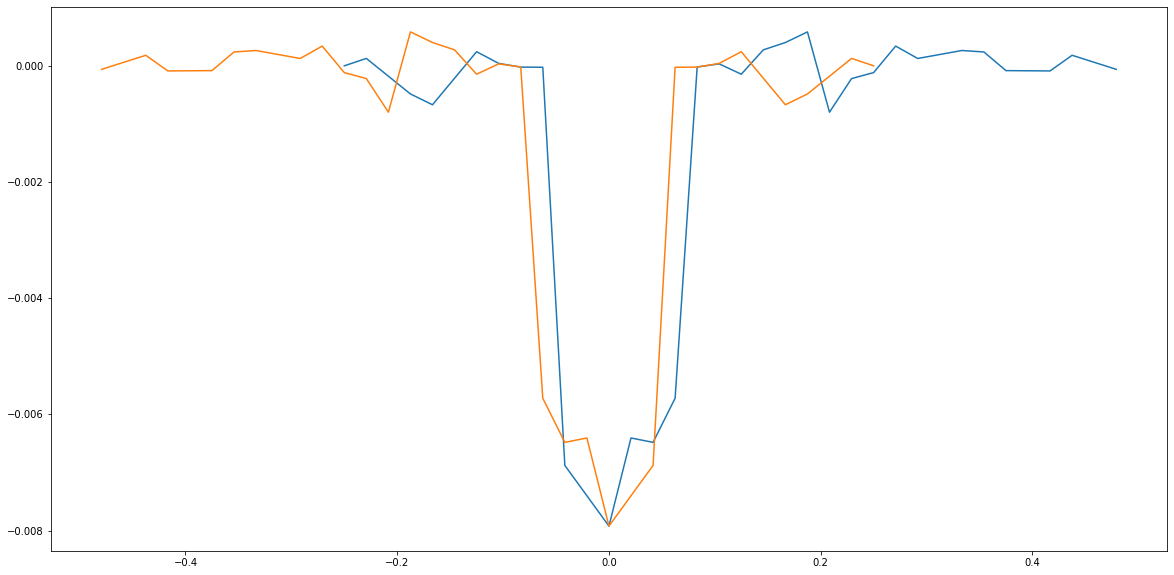

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x_forward,y_forward)
plt.plot(x_backward,y_backward)

### Now we interpolate the data, and subtract the two lightcurves

In [17]:
t = np.linspace(-0.5,0.5,5000)

diff = np.interp(t,x_forward,y_forward) - np.interp(t,x_backward,y_backward)

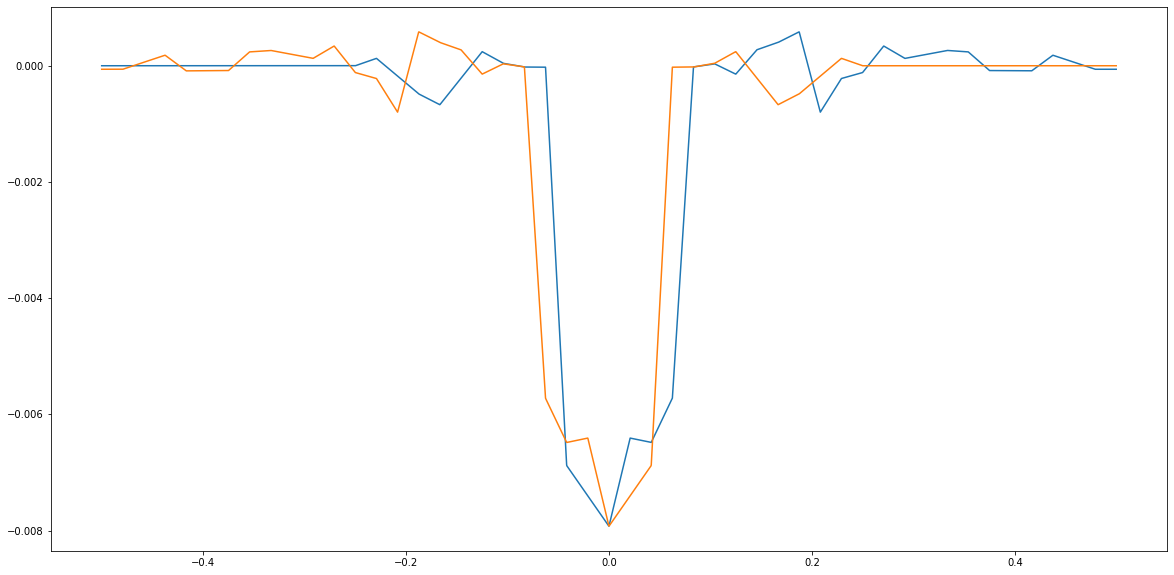

In [18]:
plt.plot(t,np.interp(t,x_forward,y_forward))
plt.plot(t,np.interp(t,x_backward,y_backward))

(0.0, 1.0)

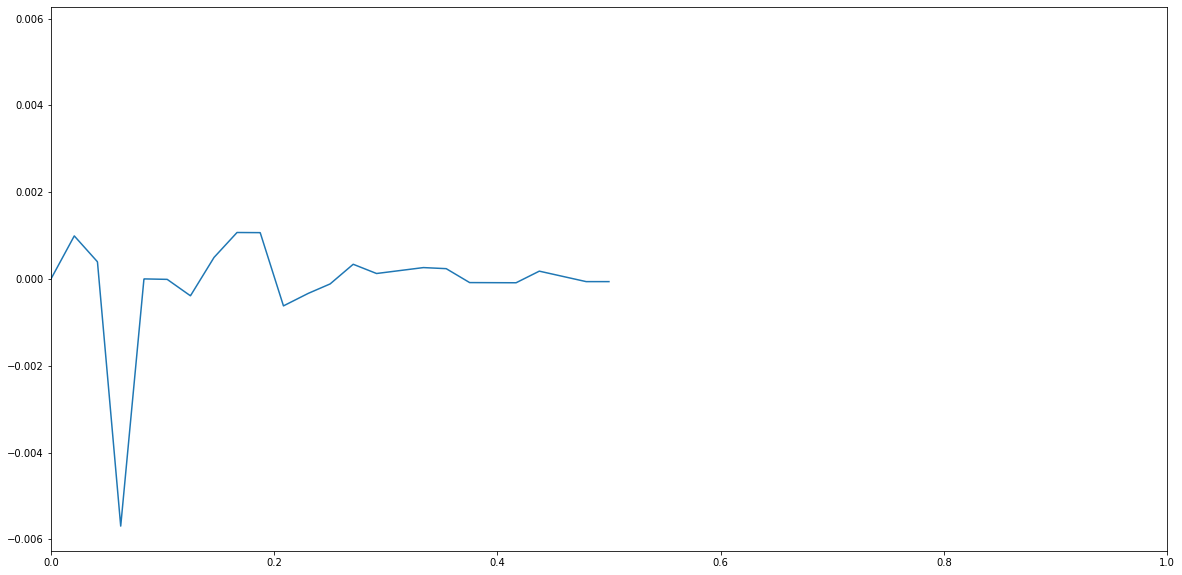

In [19]:
plt.plot(t,diff)
plt.xlim(0,1)

---

## Exocomet test

In [21]:
data, lc_info = import_lightcurve("betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits")

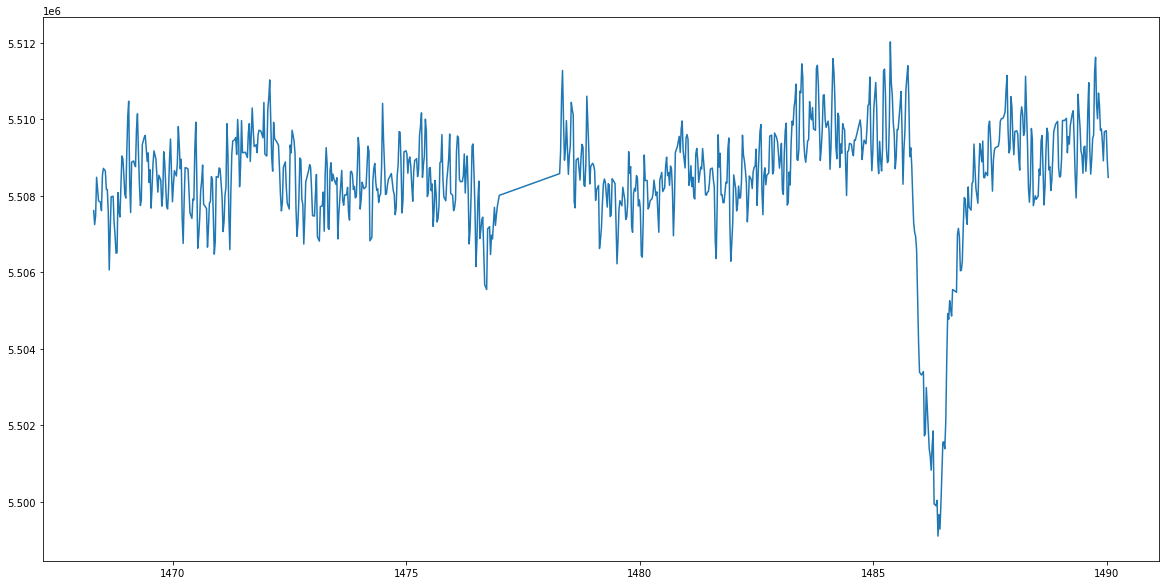

In [22]:
plt.plot(data['TIME'],data['PDCSAP_FLUX'])

In [23]:
#data = data['time','corrected flux','quality','flux error']

flat_flux, trend_flux = smoothing(data,method='median')
a = Table()
a['time'] = data[data.colnames[0]]
a['flux'] = flat_flux - np.ones(len(flat_flux))
a['quality'] = data[data.colnames[2]]
a['flux_error'] = data[data.colnames[3]]
#table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
t, flux, quality, real, flux_error = clean_data(a)
flux *= real

In [24]:
timestep = calculate_timestep(data)
factor = ((1/48)/timestep)

T1 = test_statistic_array(flux,60 * factor)

m, n = np.unravel_index(
T1.argmin(), T1.shape
)  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T1[m, n]
#Ts = nonzero(T1[m,n]).std()
minT_time = t[n]
minT_duration = m * timestep
Tm_start = n-math.floor((m-1)/2)
Tm_end = Tm_start + m
Tm_depth = flux[Tm_start:Tm_end].mean() 
Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic

In [25]:
asym, width1, width2, depth, info = calc_shape(m,n,t,flux,quality,flux_error,n_m_bg_start=2)
s = classify(m,n,real,asym)

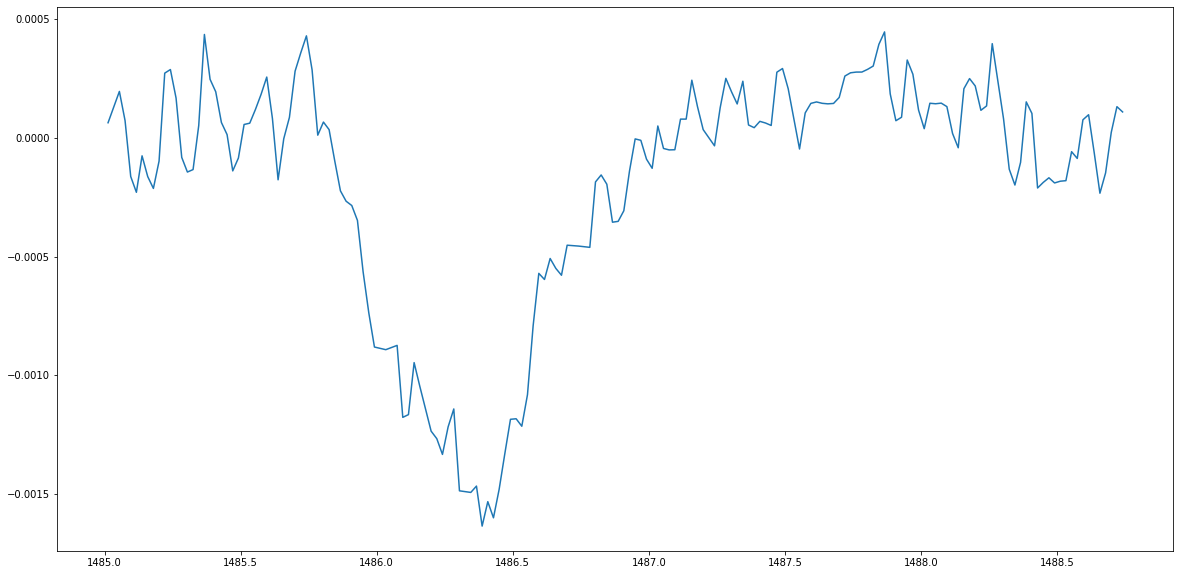

In [26]:
plt.plot(info[0],info[1])

In [27]:
asym

0.9628914398489432

In [28]:
t = info[0]
flux = info[1]

In [29]:
min_flux_ind = np.argmin(flux)

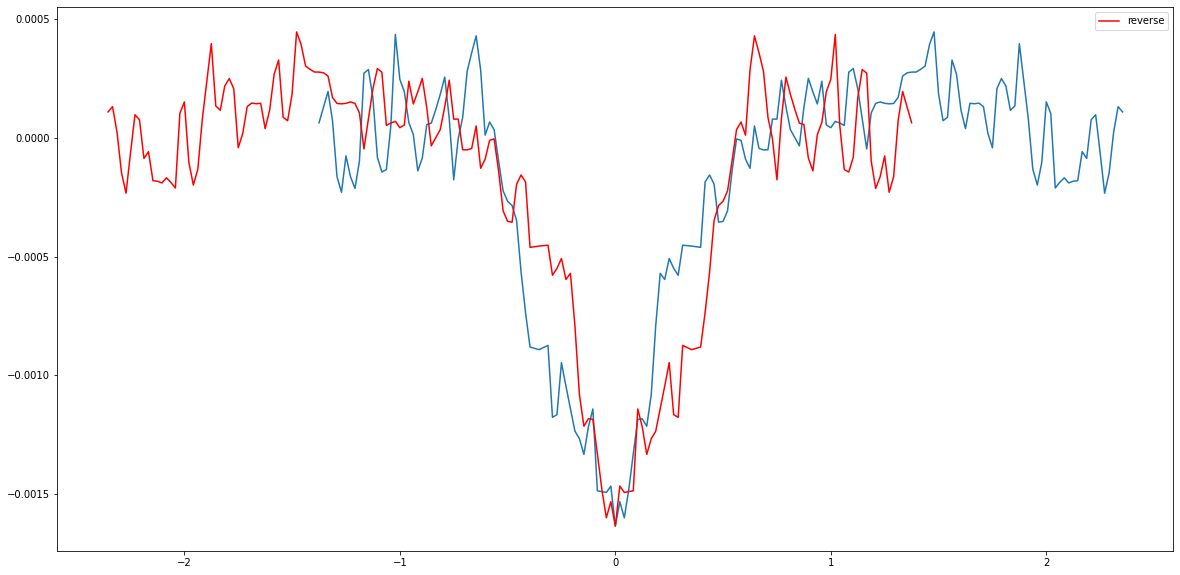

In [30]:
plt.figure(figsize=(20,10))
plt.plot(t - t[min_flux_ind],flux)


#plt.plot(t - t[min_flux_ind],np.roll(flux,5),color='blue',label='original shifted')
#plt.plot(time - time[min_flux_ind],flux,color='black',label='original')
plt.plot(t[::-1]-t[np.argmin(flux[::-1])],flux,color="red",label='reverse')
plt.legend()

In [31]:
x_forward = t - t[min_flux_ind]
y_forward = flux

In [32]:
x_backward = (t[::-1]-t[np.argmin(flux[::-1])])[::-1]
y_backward = flux[::-1]

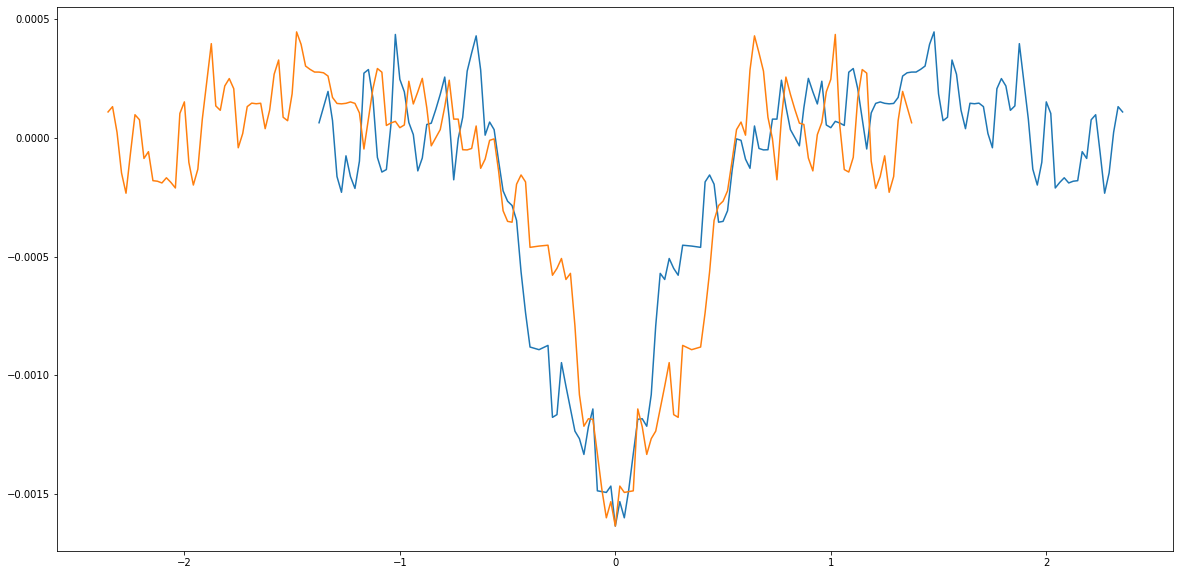

In [33]:
plt.figure(figsize=(20,10))
plt.plot(x_forward,y_forward)
plt.plot(x_backward,y_backward)

In [34]:
t = np.linspace(-1,1,5000)
diff = np.interp(t,x_forward,y_forward) - np.interp(t,x_backward,y_backward)

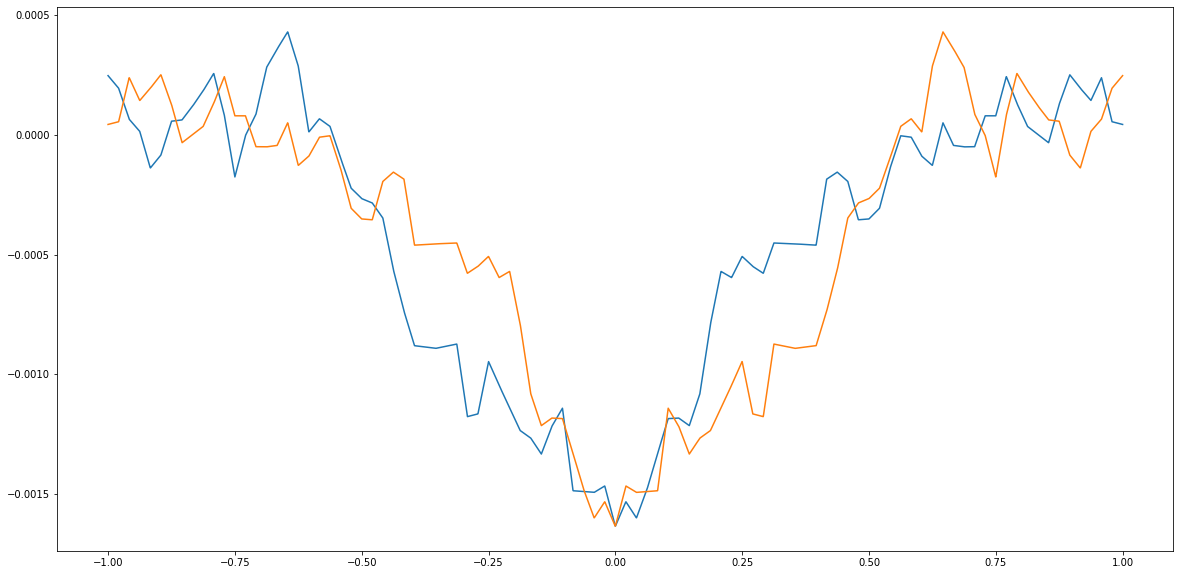

In [35]:
plt.plot(t,np.interp(t,x_forward,y_forward))
plt.plot(t,np.interp(t,x_backward,y_backward))

(0.0, 1.0)

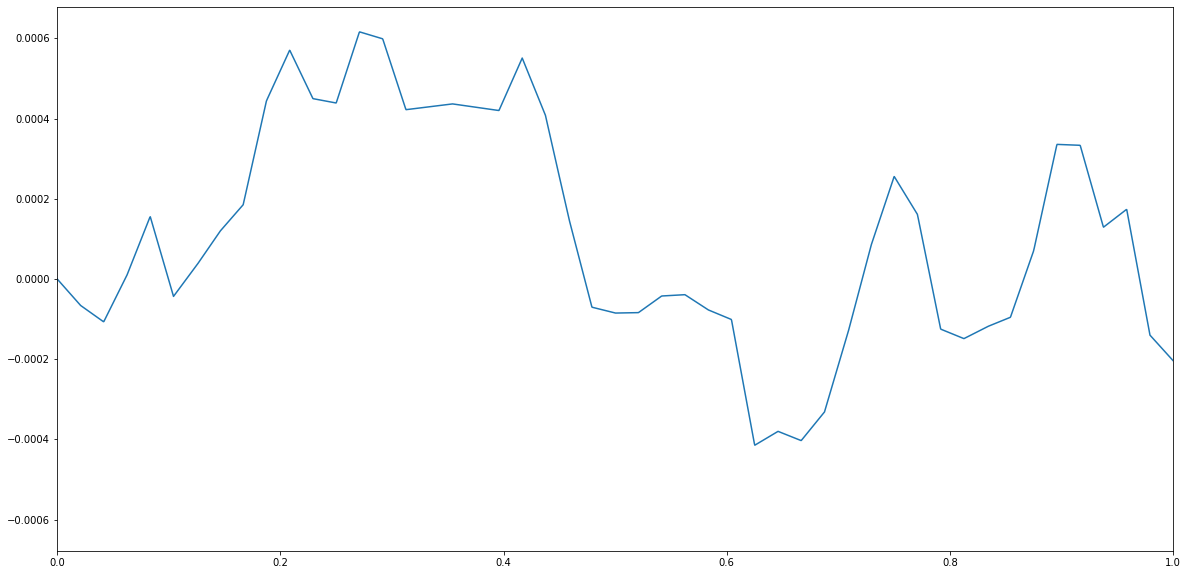

In [36]:
plt.plot(t,diff)
plt.xlim(0,1)